In [49]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import imageio

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Specify transforms using torchvision.transforms as transforms library


transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [6]:
train_set = datasets.ImageFolder("data/train", transform = transformations)
val_set = datasets.ImageFolder("data/val", transform = transformations)

In [9]:
len(val_set)

469

In [10]:
len(train_set)

1306

In [13]:
class_names  = train_set.classes

In [17]:
# Creating Data_Loader with a batch size of 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

In [54]:
# Creating Data_Loader with a batch size of 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

In [65]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


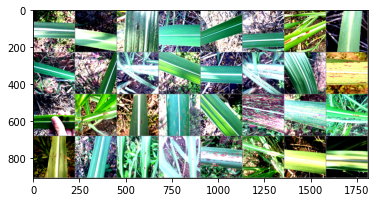

In [66]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(torchvision.utils.make_grid(images))

In [67]:
model = models.resnet50(pretrained= True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/frostman/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [98]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [70]:
#Using the pretrained model we Dont Train the initial layers.
for param in model.parameters():
    param.requires_grad = True #Set True to train the whole network

In [71]:

# Creating final fully connected Layer that accorting to the no of classes we require
# When training the complete model on our own dataset , we omit the the following sequential layer
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512,len(class_names)),
                                 nn.LogSoftmax(dim=1))

# Loss and optimizer
criterion = nn.NLLLoss()
#optimizer = optim.SGD(model.fc.parameters(), lr=0.01)

In [75]:
optimizer = optim.SGD([
        {'params': model.conv1.parameters(), 'lr':1e-4},
        {'params': model.layer1.parameters(), 'lr':1e-4},
        {'params': model.layer2.parameters(),'lr':1e-4},
        {'params': model.layer3.parameters(),'lr':1e-3},
        {'params': model.layer4.parameters() ,'lr':1e-3},
        {'params': model.fc.parameters(), 'lr': 1e-2}   # the classifier needs to learn weights faster
    ], lr=0.001, weight_decay=0.0005)

In [79]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [81]:
# Restarts the learning rate after every 5 epoch
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0= 5, 
        T_mult= 1,
    )

In [82]:
epochs = 20
best_acc = 0.0
iters = len(train_loader)

In [83]:
train_loss, val_loss = [], []

In [113]:
epochs = 20
best_acc = 0.0
iters = len(train_loader)

train_loss, val_loss = [], []

for epoch in range ( epochs ):

    train_loss_epoch = 0
    valid_loss_epoch = 0
    accuracy = 0

    # Trainin_the_ model

    model.train ()
    counter = 0
    for i, sample in enumerate ( train_loader ):
        inputs, labels = sample

        # Move_to _device_ lets burn that GPU baby !!
        inputs, labels = inputs.to ( device ), labels.to ( device )

        # Clear Optimizers
        optimizer.zero_grad ()

        # Forward Pass
        logps = model.forward ( inputs )

        # Loss
        loss = criterion ( logps, labels )

        # Backprop (Calculate Gradients)
        loss.backward ()

        # Adjust parameters based on gradients
        optimizer.step ()

        # Reduce the LR with Cosine Annealing
        scheduler.step ( epoch + i / iters )


        # Add the loss to the trainininputs.size ( 0 )g set's running loss
        train_loss_epoch += loss.item () * inputs.size ( 0 )


        # Print the progress of our training
        counter += 1
        print ( counter, "/", len ( train_loader ) )

    ####----------evaluating_model---------------#####################

    model.eval ()
    counter = 0

    # Tell torch not to calculate gradients
    with torch.no_grad ():

        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to ( device ), labels.to ( device )

            # Forward pass
            output = model.forward ( inputs )

            # Calculate Loss
            valloss = criterion ( output, labels )

            # Add loss to the validation set's running loss
            valid_loss_epoch += valloss.item () * inputs.size ( 0 )

            # Since our model outputs a LogSoftmax, find the real
            # percentages by reversing the log function
            output = torch.exp ( output )

            # Get the top class of the output
            top_p, top_class = output.topk ( 1, dim=1 )

            # See how many of the classes were correct?
            equals = top_class == labels.view ( *top_class.shape )

            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean ( equals.type ( torch.FloatTensor ) ).item ()

            # Print the progress of our evaluation
            counter += 1
            print ( counter, "/", len ( val_loader ) )

        # Save_the_best _accuracy_model

        if (accuracy / len ( val_loader )) > best_acc:
            best_acc = accuracy / len ( val_loader )
            # best_model_wts = copy.deepcopy(model.state_dict())
            torch.save ( model.state_dict (), 'model_new.pth' )
    # Get the average loss for the entire epoch
    train_loss_epoch = train_loss / len ( train_loader.dataset )
    valid_loss_epoch = val_loss / len ( val_loader.dataset )

    # Print out the information
    print ( '\nEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format ( epoch, train_loss_epoch, valid_loss_epoch ) )
    print ( 'Accuracy: ', accuracy / len ( val_loader ) )

    train_loss.append ( train_loss_epoch )
    val_loss.append ( valid_loss_epoch )

print ( '\nBest Accuracy', best_acc )


TypeError: 'float' object is not iterable

In [19]:
x =1.8688639402389526
y= 32

In [20]:
j =0


In [21]:
j += x*y

In [22]:
j

59.803646087646484